# Mount Google Drive to Google Colab

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import Libraries

In [2]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

np.random.seed(49) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(49)
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

# Create Train and Validation Set

In [3]:
train_data_dir = "/content/drive/My Drive/Gladies_VA_Plants/VA Plants 2/VA Plants/Train"
test_data_dir = "/content/drive/My Drive/Gladies_VA_Plants/VA Plants 2/VA Plants/Test"
def split(img_height, img_width, batch_size):
  # Training Dataset
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_data_dir,
      validation_split = 0.1,
      subset = "training",
      seed = 49,
      image_size= (img_height, img_width),
      batch_size = batch_size
  )
  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_data_dir,
      validation_split = 0.1,
      subset = "validation",
      seed = 49,
      image_size= (img_height, img_width),
      batch_size = batch_size
  )
  test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      test_data_dir,
      seed = 49,
      image_size= (img_height, img_width),
      batch_size = batch_size
  )
  return train_ds, val_ds, test_ds

# Visualize the Data

Found 405 files belonging to 5 classes.
Using 365 files for training.
Found 405 files belonging to 5 classes.
Using 40 files for validation.
Found 45 files belonging to 5 classes.


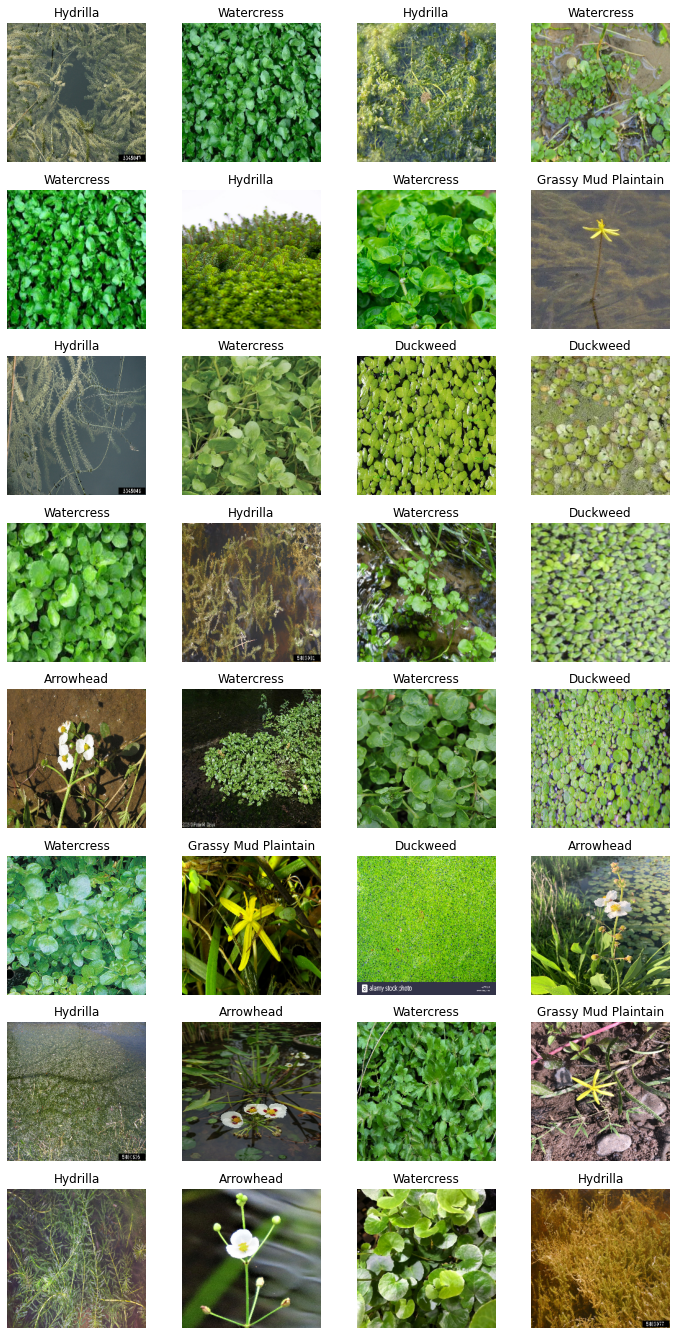

In [4]:
import matplotlib.pyplot as plt
# https://keras.io/examples/vision/image_classification_from_scratch/

img_width, img_height, batch_size = 224, 224, 32
train_ds, val_ds, test_ds = split(img_width, img_height, batch_size)

class_names = ['Arrowhead',  'Duckweed', 'Grassy Mud Plaintain', 'Hydrilla',  'Watercress']
# Rows and columns are set to fit one training batch (32)
n_rows = int(batch_size/4)
n_cols = int(batch_size/n_rows)
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
        plt.subplots_adjust(wspace=.2, hspace=.2)

# Data Augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(-0.1, 0.1)
    ]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


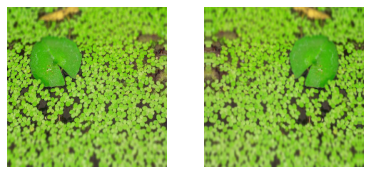

In [6]:
def sample_augmentation(train_ds):
  plt.figure(figsize=(10, 10))
  for images, _ in train_ds.take(10):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")
    ax = plt.subplot(3, 3, 2)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

sample_augmentation(train_ds)

# Modeling

# Xception

In [7]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=18, activation='softmax'),
])


In [8]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [9]:
batch_size = 32
train_set = train_ds.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess)).batch(batch_size).prefetch(1)
valid_set = val_ds.map(preprocess).batch(batch_size).prefetch(1)

In [10]:
n_classes = 5
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 1s 0us/step


In [11]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_5
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_6
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_7
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_a

# SGD

In [12]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30)

Epoch 1/30
12/12 [==============================] - 351s 27s/step - loss: 1.4935 - accuracy: 0.3428 - val_loss: 1.7378 - val_accuracy: 0.2000
Epoch 2/30
12/12 [==============================] - 324s 25s/step - loss: 0.5707 - accuracy: 0.9155 - val_loss: 1.1516 - val_accuracy: 0.5750
Epoch 3/30
12/12 [==============================] - 321s 25s/step - loss: 0.1372 - accuracy: 0.9804 - val_loss: 1.0691 - val_accuracy: 0.6000
Epoch 4/30
12/12 [==============================] - 330s 26s/step - loss: 0.0427 - accuracy: 0.9994 - val_loss: 0.6609 - val_accuracy: 0.6750
Epoch 5/30
12/12 [==============================] - 323s 25s/step - loss: 0.0282 - accuracy: 0.9963 - val_loss: 0.5164 - val_accuracy: 0.7750
Epoch 6/30
12/12 [==============================] - 333s 26s/step - loss: 0.0316 - accuracy: 0.9967 - val_loss: 0.6337 - val_accuracy: 0.8000
Epoch 7/30
12/12 [==============================] - 327s 26s/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.4753 - val_accuracy: 0.8500
Epoch 

In [13]:
score = model.evaluate(test_ds)

2/2 [==============================] - 29s 2s/step - loss: 0.0977 - accuracy: 0.9556


In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
score = model.predict(test_ds)
predicted_classes = np.argmax(np.round(score), axis=1)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

# Model Deployment

# Save and upload model to GCP

In [18]:
# Save model_1
model.save("myXception_model")

INFO:tensorflow:Assets written to: myXception_model/assets


In [19]:
model_version = "v0001"
model_name = "myXception_model"
model_path = os.path.join(model_name, model_version)
model_path

'myXception_model/v0001'

In [20]:
for root, dirs, files in os.walk(model_name):
    indent = '    ' * root.count(os.sep)
    print('{}{}/'.format(indent, os.path.basename(root)))
    for filename in files:
        print('{}{}'.format(indent + '    ', filename))

myXception_model/
    saved_model.pb
    assets/
    variables/
        variables.data-00000-of-00001
        variables.index


In [21]:
!saved_model_cli show --dir {model_path}

Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 990, in main
    args.func(args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 697, in show
    _show_tag_sets(args.dir)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 62, in _show_tag_sets
    tag_sets = saved_model_utils.get_saved_model_tag_sets(saved_model_dir)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_utils.py", line 88, in get_saved_model_tag_sets
    saved_model = read_saved_model(saved_model_dir)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_utils.py", line 55, in read_saved_model
    raise IOError("SavedModel file does not exist at: %s" % saved_model_dir)
IOError: Sav

In [22]:
!saved_model_cli show --dir {model_path} --tag_set serve

Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 990, in main
    args.func(args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 700, in show
    _show_signature_def_map_keys(args.dir, args.tag_set)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 80, in _show_signature_def_map_keys
    signature_def_map = get_signature_def_map(saved_model_dir, tag_set)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 323, in get_signature_def_map
    meta_graph = saved_model_utils.get_meta_graph_def(saved_model_dir, tag_set)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_utils.py", line 113, in get_meta_graph_def
    saved_model = read_

In [23]:
!saved_model_cli show --dir {model_path} --tag_set serve \
                      --signature_def serving_default

Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 990, in main
    args.func(args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 702, in show
    _show_inputs_outputs(args.dir, args.tag_set, args.signature_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 137, in _show_inputs_outputs
    tag_set)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_utils.py", line 113, in get_meta_graph_def
    saved_model = read_saved_model(saved_model_dir)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_utils.py", line 55, in read_saved_model
    raise IOError("SavedModel file does not exist at: %s" % saved_model_dir)
IOError: SavedModel file does no

In [24]:
!saved_model_cli show --dir {model_path} --all

Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 990, in main
    args.func(args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 691, in show
    _show_all(args.dir)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 272, in _show_all
    tag_sets = saved_model_utils.get_saved_model_tag_sets(saved_model_dir)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_utils.py", line 88, in get_saved_model_tag_sets
    saved_model = read_saved_model(saved_model_dir)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_utils.py", line 55, in read_saved_model
    raise IOError("SavedModel file does not exist at: %s" % saved_model_dir)
IOError: SavedModel f

# Deploy the model to Google Clooud AI Platform

In [ ]:
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: Xcecption_5classes/v0001/assets


In [ ]:
for root, dirs, files in os.walk(model_name):
    indent = '    ' * root.count(os.sep)
    print('{}{}/'.format(indent, os.path.basename(root)))
    for filename in files:
        print('{}{}'.format(indent + '    ', filename))

Xcecption_5classes/
    v0001/
        saved_model.pb
        assets/
        variables/
            variables.data-00000-of-00001
            variables.index


In [ ]:
!saved_model_cli show --dir {model_path}

The given SavedModel contains the following tag-sets:
serve


In [ ]:
!saved_model_cli show --dir {model_path} --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


In [ ]:
!saved_model_cli show --dir {model_path} --tag_set serve \
                      --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 5)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
!saved_model_cli show --dir {model_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, -1, -1, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_3'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/lo

In [25]:
project_id = "gladies-playground"

In [26]:
import googleapiclient.discovery

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "myxceptions-cd0e30bf967d.json"
model_id = "myXception_model"

In [ ]:
model_id = "myXception_model"
model_path = "projects/{}/models/{}".format(project_id, model_id)
model_path += "v0001" # if you want to run a specific version
ml_resource = googleapiclient.discovery.build("ml", "v1").projects()

In [37]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=False):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_png(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  if scale:
    return img/255.
  else:
    return img

In [ ]:
def predict_json(project, region, model, instances, version=None):
    """Send json data to a deployed model for prediction.
    Args:
        project (str): project where the Cloud ML Engine Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to Tensors.
        version (str): version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the 
            model.
    """
    # Create the ML Engine service object
    prefix = "{}-ml".format(region) if region else "ml"
    api_endpoint = "https://{}.googleapis.com".format(prefix)
    client_options = ClientOptions(api_endpoint=api_endpoint)

    # Setup model path
    model_path = "projects/{}/models/{}".format(project, model)
    if version is not None:
        model_path += "/versions/{}".format(version)

    # Create ML engine resource endpoint and input data
    ml_resource = googleapiclient.discovery.build(
        "ml", "v1", cache_discovery=False, client_options=client_options).projects()
    instances_list = instances.numpy().tolist() # turn input into list (ML Engine wants JSON)
    
    input_data_json = {"signature_name": "serving_default",
                       "instances": instances_list} 

    request = ml_resource.predict(name=model_path, body=input_data_json)
    response = request.execute()
    
    # # ALT: Create model api
    # model_api = api_endpoint + model_path + ":predict"
    # headers = {"Authorization": "Bearer " + token}
    # response = requests.post(model_api, json=input_data_json, headers=headers)

    if "error" in response:
        raise RuntimeError(response["error"])

In [41]:
def make_prediction(image, model, class_names):
    """
    Takes an image and uses model (a trained TensorFlow model) to make a
    prediction.
    Returns:
     image (preproccessed)
     pred_class (prediction class from class_names)
     pred_conf (model confidence)
    """
    image = load_and_prep_image(image)
    # Turn tensors into int16 (saves a lot of space, ML Engine has a limit of 1.5MB per request)
    image = tf.cast(tf.expand_dims(image, axis=0), tf.int16)
    # image = tf.expand_dims(image, axis=0)
    preds = predict_json(project=PROJECT,
                         region=REGION,
                         model=model,
                         instances=image)
    pred_class = class_names[tf.argmax(preds[0])]
    pred_conf = tf.reduce_max(preds[0])
    return image, pred_class, pred_conf

In [45]:
import matplotlib.pyplot as plt

def pred_and_plot(model, image, class_names):
  pred_probs = model.predict(tf.expand_dims(image, axis=0))
  pred_class = class_names[tf.argmax(pred_probs[0])]
  
  plt.figure()
  plt.imshow(image/255)
  plt.title(f"{pred_class}, prob: {tf.reduce_max(pred_probs):.2f}")
  plt.axis(False);

In [ ]:
make_prediction(image, model, class_names)

In [38]:
hydrilla_img= load_and_prep_image("/content/drive/My Drive/Gladies_VA_Plants/VA Plants 2/VA Plants/image/hydrilla12.png")
arrowhead_img= load_and_prep_image("/content/drive/My Drive/Gladies_VA_Plants/VA Plants 2/VA Plants/image/ar.png")
duckweed_img = load_and_prep_image("/content/drive/My Drive/Gladies_VA_Plants/VA Plants 2/VA Plants/image/duckweed.png")
grassy_img = load_and_prep_image("/content/drive/My Drive/Gladies_VA_Plants/VA Plants 2/VA Plants/image/grassy.png")
watercress_img = load_and_prep_image("/content/drive/My Drive/Gladies_VA_Plants/VA Plants 2/VA Plants/image/watercress.png")

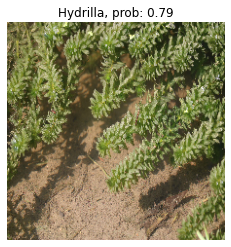

In [47]:
pred_and_plot(model=myXception_model/,
              image=hydrilla_img,
              class_names=class_names)

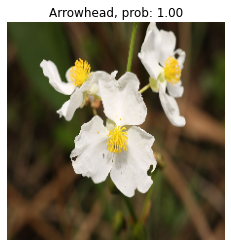

In [48]:
pred_and_plot(model=myXception_model/,
              image=arrowhead_img,
              class_names=class_names)

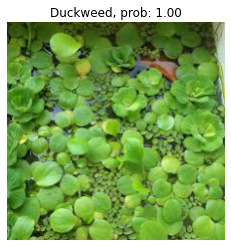

In [49]:
pred_and_plot(model=myXception_model/,
              image=duckweed_img,
              class_names=class_names)

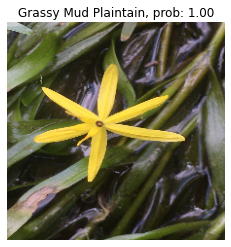

In [50]:
pred_and_plot(model=myXception_model/,
              image=grassy_img,
              class_names=class_names)

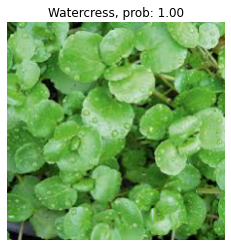

In [52]:
pred_and_plot(model=myXception_model/,
              image=watercress_img,
              class_names=class_names)